# RNAseq differential expression analysis of TEs in Drosophila melanogaster (DmGoth lineage)

## Alignment to TE Consensus sequences

Warning : We are now using DFam consensus, keeping the in

TE consensus sequences are contained in D_mel_transposon_sequence_set.fa (downloaded from https://github.com/bergmanlab/transposons/ )
By aligning reads to these sequences, we can identify which TEs are expressed and get countings.

Commands : 
```
~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC29.fastq.gz | samtools sort -o FC29.against_consensus.bam

~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC30.fastq.gz | samtools sort -o FC30.against_consensus.bam
```
We get two bam files as a result (FC29 : 5.2Go, FC30 : 1.8Go )

## Some informations on our reads...

Here's an example of what's in D_mel_transposon_sequence_set.fa : 
```
>1731#LTR/Copia
TGTTGAATATAGGCAATGCCCACATGTGTGTTGAATATAGGCAATTTCCACATGTGCATA
TGTAATTTTGTATGAGAACATACATACATACACATGAACTGTATGTATGTATATATATTA
```

And here's the beginning of the BAM we get by aligning our reads to the TEs consensus sequences : 
```
e1bae963-07b0-44fa-8a67-ae90f86c4ba0    2064    Tc3#DNA/Tc1-Mariner     331     38      710H32M5D19M2D8M1D5M1D18M1D4M1D124M1384H        *       0
       0       GGTTTTACGCTTCTAACTTGACTTCTTGTTTGTTAAATCTCGAAAGTTAAATTCTTTTGATTCTAAATATAAATTATCTTTTTAATTTTTTCTCAAATGGTCCGCGAAAAGTCTTTATCCGATTTTGAAAAAGGTCAAATCAAAGGCTATATTGAATCTGGTTTAAAACACTGTGTAATAGCCAAGAAAATCGGTTGAAGTCAAAACGTT      53/a:/-$7)4/($,%"/$#''-2#"$-5'"''$#'&$%'$"+2%4)*+/)(:?-L/$)2(('#/7+(,$+.#&%(%#&'0-%+(*16995,0.*?;3;9;+*+*/(--)&"%()%8<89210OG?*)NPMPKGC)6>:>*/H5?;-%3/2B4.DLL./A8<:*'A>-"1%#)0255A<*5H2.N(JQ@=J+?@A+-6L7K4)KT1=@WR      NM:i:35 ms:i:115        AS:i:115        nn:i:0  tp:A:P  cm:i:9  s1:i:64 s2:i:0  de:f:0.1389     SA:Z:McClintock#LTR/Gypsy,592,+,1229S153M2I920S,60,11;  rl:i:0
```

We want to count how many reads are aligned on each TEs sequences BUT, we need to remind ourselves that a read can be aligned to several features, then, which one should we count ?

Another thing to take into account :
They are primary, secondary, supplementary and unmapped reads. Which one should we count and not count ?
I guess we should discard supplementary alignments and unmapped reads.
Let's check manually how many primary and secondary reads we got.


#### Example case of a supplementary read : e1bae963-07b0-44fa-8a67-ae90f86c4ba0

This read generate two alignments : one primary (in McClintock#LTR/Gypsy) and one supplementary (in Tc3#DNA/Tc1-Mariner). The alignment score is better in the primary. In both case, the alignment covers a very small part of the consensus sequence...

## Re-aligning with a different consensus file :

Bergman consensus gtf contained very small sequences of TE... Trying again with new TE sequences from DFAM ([https://dfam.org/browse?clade=7215&clade_descendants=true])

*Downloading those sequences using FASTA button at the bottom of the page...*

Those TE sequences are often fragmented in 2 parts : the intern part and the LTR part.
We need to match the LTR part at the beginning and the end of the intern part.

Two possibilities to match intern and LTR part : {TE_name}_I / {TE_name}_LTR OR {TE_name}-I_DM / {TE_name}-LTR_DM

I wrote a tool to generate a consensus fasta file with merged intern and ltr part here : [https://github.com/EricAmren/TE_LTR_flanker](https://github.com/EricAmren/TE_LTR_flanker)



In [1]:
import pysam
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dtale

# FC29_bamfile = "data/consensus/bam/FC29.against_consensus.bam"
# FC30_bamfile = "data/consensus/bam/FC30.against_consensus.bam"
# consensus_fasta_file = "data/consensus/D_mel_transposon_sequence_set.fa"


FC29_bamfile = "data/consensus/bam/FC29.against_DFam_consensus.bam"
FC30_bamfile = "data/consensus/bam/FC30.against_DFam_consensus.bam"
consensus_fasta_file = "data/consensus/families.flanked_LTR.hierarchy.fa"

In [18]:
unmapped = 0
supp = 0
secondary = 0
primary = 0
with pysam.AlignmentFile(FC29_bamfile, 'rb') as bam1:
    for ali in bam1:
        if ali.is_supplementary:
            supp += 1
        elif ali.is_unmapped:
            unmapped += 1
        elif ali.is_secondary:
            secondary += 1
        else:
            primary += 1
total = sum([supp, unmapped, secondary, primary])
male_counts = [total, primary, secondary, supp, unmapped]

unmapped = 0
supp = 0
secondary = 0
primary = 0
with pysam.AlignmentFile(FC30_bamfile, 'rb') as bam1:
    for ali in bam1:
        if ali.is_supplementary:
            supp += 1
        elif ali.is_unmapped:
            unmapped += 1
        elif ali.is_secondary:
            secondary += 1
        else:
            primary += 1
total = sum([supp, unmapped, secondary, primary])
female_counts = [total, primary, secondary, supp, unmapped]

counts_list = [female_counts, male_counts]
counts_df = pd.DataFrame(counts_list, columns=["Total", "Primary", "Secondary", "Supplementary", "Unmapped"])
counts_df.insert(1, "Sex", ["Female", "Male"], True)
counts_df.set_index("Sex")

,Total,Primary,Secondary,Supplementary,Unmapped
Sex,,,,,
Female,1236534,1341,501,33,1234659
Male,2928158,8102,2000,604,2917452


Nombre de reads s'alignant sur le premier fichier de consensus. (On a globalement pas bougé)

| Sex    | Total   | Primary | Secondary | Supplementary | Unmapped |
| ------ | ------- | ------- | --------- | ------------- | -------- |
| Female | 1236291 | 1241    | 262       | 29            | 1234759  |
| Male   | 2926979 | 7372    | 1000      | 425           | 2918182  |



99.7% of those reads were mapped against dmgoth genome. 

In [ ]:
ratio_mapped_female = counts_df["Primary"][0]/counts_df["Total"][0]
print("Ratio of read mapped to ET (Female) = " + str(ratio_mapped_female))

ratio_mapped_male = counts_df["Primary"][1]/counts_df["Total"][1]
print("Ratio of read mapped to ET (Male) = " + str(ratio_mapped_male))

In [2]:
FC29_alignments = pysam.AlignmentFile(FC29_bamfile, 'rb')
read_index = pysam.IndexedReads(FC29_alignments)
read_index.build()

## Generating the dataframe : Counts per Subclass, superfamily,family

In [25]:
def get_countings_from_bam(bamfile):
    counting_dict = dict()
    alignment_file = pysam.AlignmentFile(bamfile, 'rb')
    for ali in alignment_file:
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            if not ali.reference_name in counting_dict :
                counting_dict[ali.reference_name] = 0
            counting_dict[ali.reference_name] += 1
    return counting_dict

consensus_counting_female_dict = get_countings_from_bam(FC30_bamfile)
consensus_counting_male_dict = get_countings_from_bam(FC29_bamfile)

full_consensus_counting_dict = dict()
for feature in consensus_counting_female_dict:
    if not feature in consensus_counting_male_dict :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], 0]
    else :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], consensus_counting_male_dict[feature]]

for feature in consensus_counting_male_dict:
    if not feature in consensus_counting_female_dict :
        full_consensus_counting_dict[feature] = [0, consensus_counting_male_dict[feature]]

total_count_female = 0
total_count_male = 0
for count_female, count_male in full_consensus_counting_dict.values():
    total_count_female += count_female
    total_count_male += count_male

full_consensus_ratio_dict = dict()
for feature, counting in full_consensus_counting_dict.items():
    female_ratio = 0 if counting[0] == 0 else counting[0]/total_count_female
    male_ratio = 0 if counting[1] == 0 else counting[1]/total_count_male
    full_consensus_ratio_dict[feature] = [female_ratio, male_ratio]

consensus_counting_df = pd.DataFrame.from_dict(full_consensus_counting_dict)
consensus_counting_df = consensus_counting_df.T
consensus_counting_df.columns = ["Female", "Male"]
consensus_counting_df.index.name = "ID"
consensus_TE_counts_df = consensus_counting_df.copy()
te_family_names = []
te_super_families = []
te_subclasses = []
for te in consensus_TE_counts_df.index :
    te_family_name, te_subclass, te_super_family = re.split('#|/', te)
    te_family_names.append(te_family_name)
    te_super_families.append(te_super_family)
    te_subclasses.append(te_subclass)
consensus_TE_counts_df.insert(0, "Family", te_family_names)
consensus_TE_counts_df.insert(1, "SuperFamily", te_super_families)
consensus_TE_counts_df.insert(2, "SubClass", te_subclasses)

def get_TE_mean_subject_coverage(genome_file, bamfile):
    feature_list = []
    with open(genome_file, 'r') as genome:
        for line in genome:
            if line.startswith(">"):
                feature_list.append(line[1:].strip())
    alignments = pysam.AlignmentFile(bamfile)

    feature_lengths_dict = {feature_list[i]: alignments.lengths[i] for i in range(len(feature_list))}
    TE_subject_coverage = dict()
    for feature, feature_length in feature_lengths_dict.items():            
        ali_iter = alignments.fetch(feature)
        subject_coverage_list = []
        for ali in ali_iter:
            if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped:
                subject_coverage_list.append(ali.reference_length / feature_length)
        if len(subject_coverage_list) == 0 :
            TE_subject_coverage[feature] = 0
        else: 
            mean_subject_coverage = sum(subject_coverage_list) / len(subject_coverage_list)
            TE_subject_coverage[feature] = mean_subject_coverage
    return TE_subject_coverage

female_TE_subject_coverage = get_TE_mean_subject_coverage(consensus_fasta_file, FC30_bamfile)
male_TE_subject_coverage = get_TE_mean_subject_coverage(consensus_fasta_file, FC29_bamfile)

## Adding ratio to big dataframe
female_consensus_ratio_dict = {k:v[0] for k,v in full_consensus_ratio_dict.items()}
male_consensus_ratio_dict = {k:v[1] for k,v in full_consensus_ratio_dict.items()}
consensus_TE_counts_df['Female_Ratio'] = consensus_counting_df.index.to_series().map(female_consensus_ratio_dict)
consensus_TE_counts_df['Male_Ratio'] = consensus_counting_df.index.to_series().map(male_consensus_ratio_dict)

## Adding subject coverage to big dataframe
consensus_TE_counts_df['Female_subject_coverage'] = consensus_counting_df.index.to_series().map(female_TE_subject_coverage)
consensus_TE_counts_df['Male_subject_coverage'] = consensus_counting_df.index.to_series().map(male_TE_subject_coverage)

## Make sure that every columns is in the right order :
consensus_TE_counts_df = consensus_TE_counts_df[['Family', 'SuperFamily', 'SubClass', 'Female', 'Male', 'Female_Ratio', 'Male_Ratio', 'Female_subject_coverage', 'Male_subject_coverage']]

In [51]:
consensus_TE_counts_df.head()

,Family,SuperFamily,SubClass,Female,Male,Female_Ratio,Male_Ratio,Female_subject_coverage,Male_subject_coverage
ID,,,,,,,,,
Baggins1#LINE/R1-LOA,Baggins1,R1-LOA,LINE,3,21,0.002237,0.002592,0.089553,0.096976
BARI_DM#DNA/TcMar-Tc1,BARI_DM,TcMar-Tc1,DNA,1,1,0.000746,0.000123,0.756944,0.174769
BS#LINE/I-Jockey,BS,I-Jockey,LINE,4,8,0.002983,0.000987,0.042918,0.278604
BS2#LINE/I-Jockey,BS2,I-Jockey,LINE,1,17,0.000746,0.002098,0.131752,0.261086
CIRCE#LTR/Gypsy,CIRCE,Gypsy,LTR,3,39,0.002237,0.004814,0.081236,0.099050


## Exporting dataframe to csv...

In [52]:
consensus_TE_counts_df.to_csv("consensus_counting.csv")

consensus_ratio_df = pd.DataFrame.from_dict(full_consensus_ratio_dict)
consensus_ratio_df = consensus_ratio_df.T
consensus_ratio_df.columns = ["Female", "Male"]
consensus_ratio_df.index.name = "TE"
consensus_ratio_df.to_csv("consensus_TE_ratio.csv")

## Importing dataframe from CSV

In [53]:
consensus_ratio_df = pd.read_csv("consensus_TE_ratio.csv", index_col="TE")
consensus_counting_df = pd.read_csv("consensus_counting.csv", index_col="ID")

consensus_ratio_df.head()


,Female,Male
TE,,
Baggins1#LINE/R1-LOA,0.002237,0.002592
BARI_DM#DNA/TcMar-Tc1,0.000746,0.000123
BS#LINE/I-Jockey,0.002983,0.000987
BS2#LINE/I-Jockey,0.000746,0.002098
CIRCE#LTR/Gypsy,0.002237,0.004814


In [54]:
consensus_counting_df.head()

,Family,SuperFamily,SubClass,Female,Male,Female_Ratio,Male_Ratio,Female_subject_coverage,Male_subject_coverage
ID,,,,,,,,,
Baggins1#LINE/R1-LOA,Baggins1,R1-LOA,LINE,3,21,0.002237,0.002592,0.089553,0.096976
BARI_DM#DNA/TcMar-Tc1,BARI_DM,TcMar-Tc1,DNA,1,1,0.000746,0.000123,0.756944,0.174769
BS#LINE/I-Jockey,BS,I-Jockey,LINE,4,8,0.002983,0.000987,0.042918,0.278604
BS2#LINE/I-Jockey,BS2,I-Jockey,LINE,1,17,0.000746,0.002098,0.131752,0.261086
CIRCE#LTR/Gypsy,CIRCE,Gypsy,LTR,3,39,0.002237,0.004814,0.081236,0.099050


## Barplot of TE expression ratio (from consensus data)

In [55]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=consensus_ratio_df.index,
    y=consensus_ratio_df["Female"],
    name='Female',
    marker_color='indianred'
))

fig.add_trace(go.Bar(
    x=consensus_ratio_df.index,
    y=consensus_ratio_df["Male"],
    name='Male',
    marker_color='blue'
))

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=1, uniformtext_mode='hide')
fig.update_layout(barmode='group', xaxis_tickangle=-45, width=1500)
fig.show()

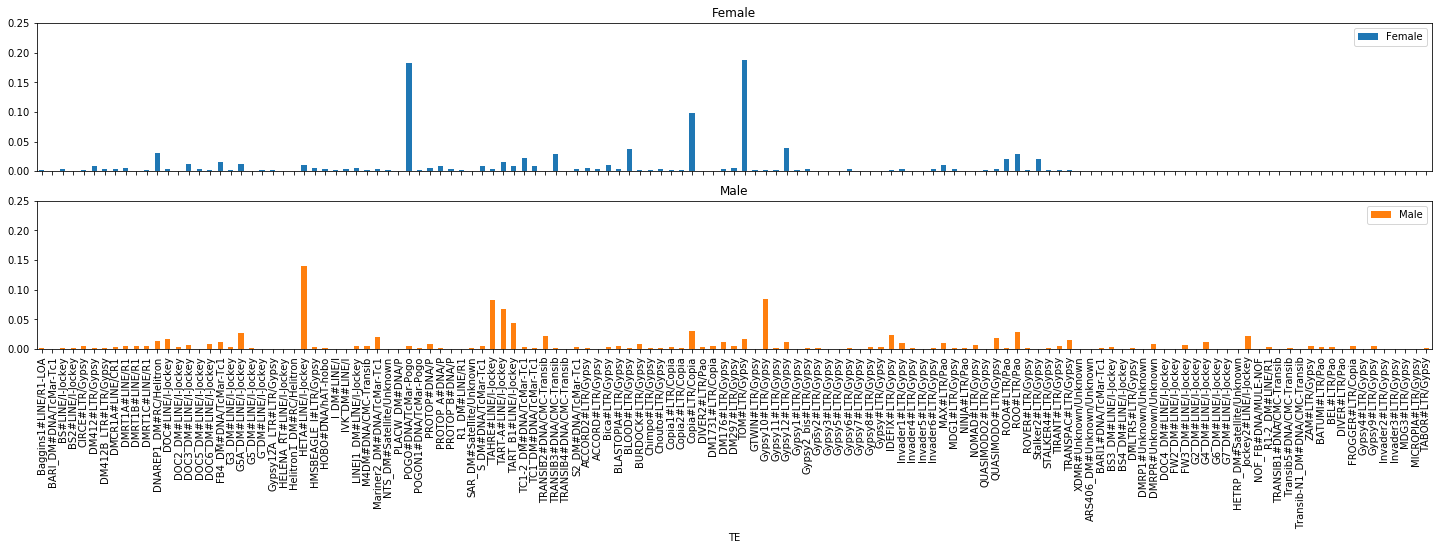

In [57]:
axs = consensus_ratio_df.plot.bar(figsize=(25,6), subplots=True, ylim=(0, 0.25))

## Pie plots : Ratio of each Subclass / Superfamily / Family

In [58]:
df = consensus_counting_df.copy()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(
    go.Pie(labels=df["SubClass"], values=df["Female"], textinfo='label+percent', name = "Female"),
    1, 1)

fig.add_trace(
    go.Pie(labels=df["SubClass"], values=df["Male"], textinfo='label+percent', name = "Male"),
    1, 2)
fig.update_traces(hole=.4, hoverinfo="label+value")

fig.update_layout(
    title_text="Ratio of expressed TE per SubClass ",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Female', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Male', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [59]:
df = consensus_counting_df.copy()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(
    go.Pie(labels=df["SuperFamily"], values=df["Female"], textinfo='label', name = "Female"),
    1, 1)

fig.add_trace(
    go.Pie(labels=df["SuperFamily"], values=df["Male"], textinfo='label', name = "Male"),
    1, 2)
fig.update_traces(hole=.4, hoverinfo="label+value+percent")

fig.update_layout(
    title_text="Ratio of expressed TE per SuperFamily ",
    annotations=[dict(text='Female', x=0.15, y=0.5, font_size=20, showarrow=False),
                 dict(text='Male', x=0.82, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [7]:
dtale.show(df)


2021-04-06 09:41:29,436 - INFO     - NumExpr defaulting to 4 threads.


In [33]:
consensus_counting_df.head()

,Family,SuperFamily,SubClass,Female,Male,Female_subject_coverage,Male_subject_coverage
ID,,,,,,,
Baggins1#LINE/R1-LOA,Baggins1,R1-LOA,LINE,3,21,0.089553,0.096976
BARI_DM#DNA/TcMar-Tc1,BARI_DM,TcMar-Tc1,DNA,1,1,0.756944,0.174769
BS#LINE/I-Jockey,BS,I-Jockey,LINE,4,8,0.042918,0.278604
BS2#LINE/I-Jockey,BS2,I-Jockey,LINE,1,17,0.131752,0.261086
CIRCE#LTR/Gypsy,CIRCE,Gypsy,LTR,3,39,0.081236,0.099050


## Male TE expression ratio and subject coverage

In [60]:
df = consensus_counting_df.copy()
expressed = df["Male"] > 0
df = df[expressed]
fig = px.sunburst(df, path=['SubClass', 'SuperFamily', 'Family'], values='Male', color = "Male_subject_coverage")
fig.show()


## Female TE expression ratio and subject coverage

In [61]:
df = consensus_counting_df.copy()
expressed = df["Female"] > 0
df = df[expressed]
fig = px.sunburst(df, path=['SubClass', 'SuperFamily', 'Family'], values='Female', color = "Female_subject_coverage")
fig.show()

#### Some trouble with the query coverage of some TEs...

The query coverage of some TE can be very low, as seen here on IGV for 1731#LTR/Copia :
![title](doc/low_QC_for_Copia.png)

When we blatted the sequence of read e687c074-c5e2-4c85-9ba0-492e6a4a8a84 (in black on previous picture), this is what we got :  

![title](doc/copia_blat_recap.png)




Our read is divided in at least four part : 
* Gene1 in orange (4 -> 1464) | FBtr0081639 (= alphaTub84B)
* Gene2 in green (1500 -> 2317) | FBtr0079204 (=CG13989)
* Copia in pink (2385 -> 4141)
* Gene3 in purple (4208 -> 5529) | FBtr0301683 (=Sinah)


One part of our read (in pink from 2385 to 4145) is aligned a bunch of time against the duplication 1731 of Copia, in several chromosomes (which is normal for a TE). Another one (in orange from 4 to 1464) is aligned three time to genes coding for a very similar protein (FBtr0081639 = alphaTub84B, which is a gene from chr3R:7086599-7088839, FBtr0081538 =alphaTub84D, another gene from chr3R:7530753-7532732 and FBtr0082087 =alphaTub85E, from chr3R:9731221-9733250).

This read seems to be chimeric : it looks like several reads glued together. To check if it is the case, we could have a look at the different sequence between each part. Maybe it's a redundant sequence that we could find in other reads, in which case it would suggest that it is an adaptator or something... We should align this in-between sequence and check if we can find it elsewhere.


In [7]:

black_read = read_index.find("e687c074-c5e2-4c85-9ba0-492e6a4a8a84")
black_read_sequence = list(black_read)[0].query_sequence
orange2green = black_read_sequence[1464:1500]
green2pink = black_read_sequence[2317:2385]
pink2purple = black_read_sequence[4141:4208]

print(len(orange2green))
print(len(green2pink))
print(len(pink2purple))

print(orange2green)
print(green2pink)
print(pink2purple)


36
68
67
AAAAAAACACCTAAGATCTCAGGCGTTTTTTTGCAT
GTAGGGATCTATAGTGAGTCGTATTACATATCAATCCATGGATTGATATGTAATCAAGCTGCACTTAA
TAATGATCGTTGTATAAAAAAAAAACCCCTGAGATCCGCAGCGTTTTTTTTTTTTTTGATTATAGCC


Only pink2purple has a blat result.
Let's compare those sequences to another read aligned to copia dup 1731 (7596c024-a22d-48a3-b6e4-ec4d75980c0a)


In [11]:
new_read = read_index.find("7596c024-a22d-48a3-b6e4-ec4d75980c0a")
new_read_sequence = list(new_read)[0].query_sequence
green2pink_2 = new_read_sequence[1502:1575]
pink2orange_2 = new_read_sequence[3362:3419]
print(green2pink_2)
print(pink2orange_2)



CTATAGTGAGTCATTGTTACATATCAATCCATGGATTGATATGTAATACGAGCTGCACATGTAACTGTACTAG
ATTAAAAAAAAAAAAACGCCTGAGATGGATTGATATGTAATACGACTCACTATTAAG


The new read can be divided in 3 parts : Copia, gene1 and gene2.
![title](doc/new_read_blat.png)

## Countings by position from genomic alignments

In [3]:
female_count_by_pos_df = pd.read_csv("results/transcript_id_FC29_counts/FC29_transcript_id_counts.filtered", sep='\t', header = None, names=['ID', 'chrom', 'start', 'end', 'strand', 'length', 'count_female'], index_col = "ID")
female_count_by_pos_df.head()

# Male
male_count_by_pos_df = pd.read_csv("results/transcript_id_FC30_counts/FC30_transcript_id_counts.filtered", sep='\t', header = None, names=['ID', 'chrom', 'start', 'end', 'strand', 'length', 'count_male'], index_col = "ID")
male_count_by_pos_df.head()

versus_count_df = pd.concat([female_count_by_pos_df, male_count_by_pos_df])
versus_count_df.fillna(0, inplace=True)
versus_count_df.head()

,chrom,start,end,strand,length,count_female,count_male
ID,,,,,,,
DNAREP1_DM_4_RaGOO_1132_1263,4_RaGOO,1132,1263,+,132,1.0,0.0
QUASIMODO2-LTR_DM_4_RaGOO_13230_19659,4_RaGOO,13230,19659,+,6430,1.0,0.0
DNAREP1_DM_4_RaGOO_152028_152132,4_RaGOO,152028,152132,+,105,2.0,0.0
PROTOP_B_4_RaGOO_175159_176280,4_RaGOO,175159,176280,+,1122,5.0,0.0
DNAREP1_DM_4_RaGOO_186866_187247,4_RaGOO,186866,187247,.,382,2.0,0.0


## 